# Tutorial 09b - CNN with PyTorch

## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **PyTorch and CNNs**.



## Setup
As first step, we need to import the necessary libraries. 

# CIFAR10 with PyTorch

Let's try to classify the CIFAR10 dataset. We can use the torchvision package to load the CIFAR10 dataset. 
After loading the dataset, we'll need to preprocess the images by reshaping them to a 1D tensor and normalizing the pixel values. The `transform` takes care of this.

Afterwards let's display some images from the dataset.

Files already downloaded and verified
Files already downloaded and verified


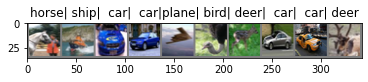

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

batch_size = 100

# Load and preprocess the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# the labels will be put in a separate vector as the original is just numbers, but we want text labels 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# display some images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show 10 images
plt.title('|'.join('% 5s' % classes[labels[j].item()] for j in range(10)))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))




## LeNet-5 in PyTorch

Below you can find the code for a (modernized) LeNet-5 architecture in PyTorch. 
Inspired by [this](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) blog post.

In [22]:
# Define a model
inputs, classes = next(iter(trainloader))
input_shape = inputs[0].shape
print("input:", input_shape)
nb_classes = 10

class CNNModel(nn.Module):

    def __init__(self, input_shape, nb_classes, legacy=True):
        super(CNNModel, self).__init__()

        self.act = nn.Sigmoid() if legacy else nn.ReLU()

        self.conv1 = nn.Conv2d(input_shape[0], 6 if legacy else 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2),)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6 if legacy else 20, 16 if legacy else 50 , kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[1]//4*input_shape[2]//4*(16 if legacy else 50), 500)
        self.fc2 = nn.Linear(500, nb_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

model = CNNModel(input_shape, nb_classes, legacy=False) # instance the model
print( "output:", model(inputs).shape ) # check the output shape of the model -> (batch_size, nb_classes)

input: torch.Size([3, 32, 32])
output: torch.Size([100, 10])


## GPU

Running the code on the GPU is easy. Just move the model and the data to the GPU with `model.to(device)` and `data.to(device)`.
You can check if you have a GPU available with `torch.cuda.is_available()`.

When data is moved to the GPU it is stored on the GPU's memory. You cannot access it from the CPU anymore. Thus, you need to move it back to the CPU with `data.cpu()`.

If you want to use a GPU in Colab, go to the menu and select **Edit** -> **Notebook settings** -> **Hardware accelerator** -> switch to **GPU**.

In [23]:
# if you want to use a GPU (recommended) use `tensor.to(device)`
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("Using CPU! things will be slow! :(")

model = model.to(device) # move the model to the GPU
output = model(inputs.to(device)) # move the input to the GPU and run the model
output = output.cpu() # move the output back to the CPU for further processing

## Training

For training we define the loss function and optimizer. Let's use the cross-entropy loss function and a stochastic gradient descent (SGD) or Adam optimizer to train the model.

Then we need to loop over the training dataset, feed the images and labels to the model, compute the loss, perform backpropagation to update the model's parameters, and repeat for a certain number of epochs.

Afterwards we can test the model on the test dataset. We can use the `torch.no_grad()` context manager to temporarily set all the requires_grad flag to false. This will reduce memory usage and speed up computations. We don't need to compute gradients in the testing phase.

In [24]:
#model = CNNModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            # move the data to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep loss for statistics
        running_loss += loss.item()
    # print statistics
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            # move the data to the GPU
            images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Epoch 1 loss: 1.360
Epoch 2 loss: 1.006
Epoch 3 loss: 0.882
Epoch 4 loss: 0.795
Epoch 5 loss: 0.729
Epoch 6 loss: 0.681
Epoch 7 loss: 0.635
Epoch 8 loss: 0.601
Epoch 9 loss: 0.561
Epoch 10 loss: 0.537
Finished Training
Accuracy of the network on the 10000 test images: 69 %


Let's look at a few images from the test set and print the model's predictions.

Accuracy: 84.00% for 50 test images


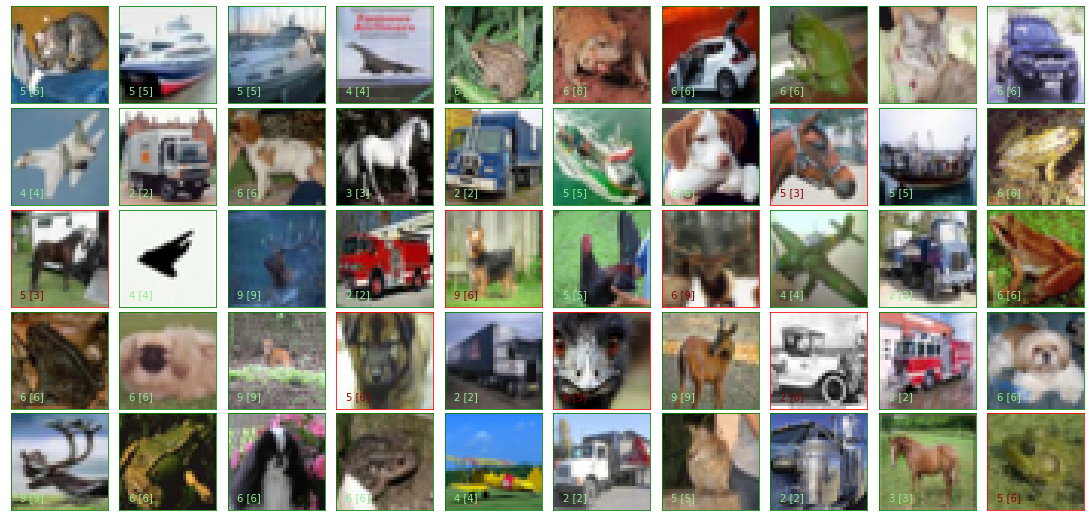

In [26]:
# get some random test images
images, labels = next(iter(testloader))

_model = model.cpu() # move the model to the CPU


# set up a figure
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

_, prediction_label = torch.max(_model(images).data, 1)

total, correct = 0, 0
# plot the images: each image is 28x28 pixels
for i,img in enumerate(images[:50]):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


    img_text = f'{classes[prediction_label[i]]} [{classes[labels[i]]}]'

    if prediction_label[i] == labels[i]:
        # label the image with the blue text
        ax.text(0.1, 0.1, img_text, color='lightgreen', transform=ax.transAxes)
        ax.tick_params(color='green', labelcolor='green')
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
        correct += 1
    else:
        # label the image with the red text
        ax.text(0.1, 0.1, img_text, color='darkred', transform=ax.transAxes)
        ax.tick_params(color='red', labelcolor='red')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
    total += 1

print(f'Accuracy: {correct/total*100:.2f}% for {total} test images')